
# Clasificación de Imágenes de Animales

**Objetivo**: Entrenar un modelo de redes neuronales convolucionales (CNN) para clasificar imágenes de animales utilizando un dataset organizado en subdirectorios.

El dataset contiene imágenes organizadas por carpetas, donde cada carpeta representa una categoría (e.g., `antelope`, `bear`). Esta libreta está estructurada de la siguiente manera:

1. Carga del dataset y preprocesamiento de las imágenes.
2. Construcción de un modelo de CNN utilizando TensorFlow/Keras.
3. Entrenamiento del modelo y ajuste de hiperparámetros.
4. Evaluación del rendimiento del modelo con métricas y visualizaciones.


In [131]:

# Importando las bibliotecas necesarias
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau


## Parámetros Generales

Aquí definimos los parámetros de entrenamiento como `BATCH_SIZE`, `EPOCHS` y la tasa de aprendizaje (`LEARNING_RATE`), que hacen que sea fácil ajustar los hiperparámetros sin necesidad de modificar otras partes del código.

In [132]:
# Parámetros generales del entrenamiento
BATCH_SIZE = 32
EPOCHS = 50
dataset_path = "./animals/animals"
labels_file = "./animals/name of the animals.txt"



## Carga del Dataset

El dataset está organizado en subdirectorios dentro de `animals/animals`. Cada subdirectorio corresponde a una categoría de animal.


In [133]:

# Reading labels
with open(labels_file, 'r') as f:
    animal_names = f.read().split('\n')

# Image Preprocessing using OpenCV
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    return image

# Create dataset
data = []
labels = []

for animal in animal_names:
    animal_dir = os.path.join(dataset_path, animal)
    for img_name in os.listdir(animal_dir):
        img_path = os.path.join(animal_dir, img_name)
        data.append(preprocess_image(img_path))
        labels.append(animal)

data = np.array(data)
labels = np.array(labels)

# Display the first few animal names
animal_names[:10]

# Cargar modelo .keras
#model = keras.models.load_model('model.keras')

['raccoon',
 'penguin',
 'parrot',
 'panda',
 'lobster',
 'goat',
 'duck',
 'dog',
 'cat',
 'bear']


## Preprocesamiento de las Imágenes

Normalizamos las imágenes y aplicamos aumentación de datos para mejorar la generalización del modelo.


In [134]:
# Generador de imágenes con aumentación
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Separar un porcentaje para validación
)

# Generadores de datos para entrenamiento y validación
train_data = image_gen.flow_from_directory(
    base_path,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = image_gen.flow_from_directory(
    base_path,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 480 images belonging to 10 classes.
Found 120 images belonging to 10 classes.


## Creació del model

In [136]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load the EfficientNetB3 model with pre-trained weights
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

#model.add(layers.Flatten(input_shape=(150, 150, 3)))  # Update the input shape

#model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dense(10, activation='relu'))  # Update the number of units to match the number of classes

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation and learning rate scheduling
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lr_scheduler])

NameError: name 'LabelEncoder' is not defined

## Evaluar el entrenamiento

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.1375 - loss: 5.8789

Precisión en el conjunto de test: 0.1667
Pérdida en el conjunto de test: 6.1175


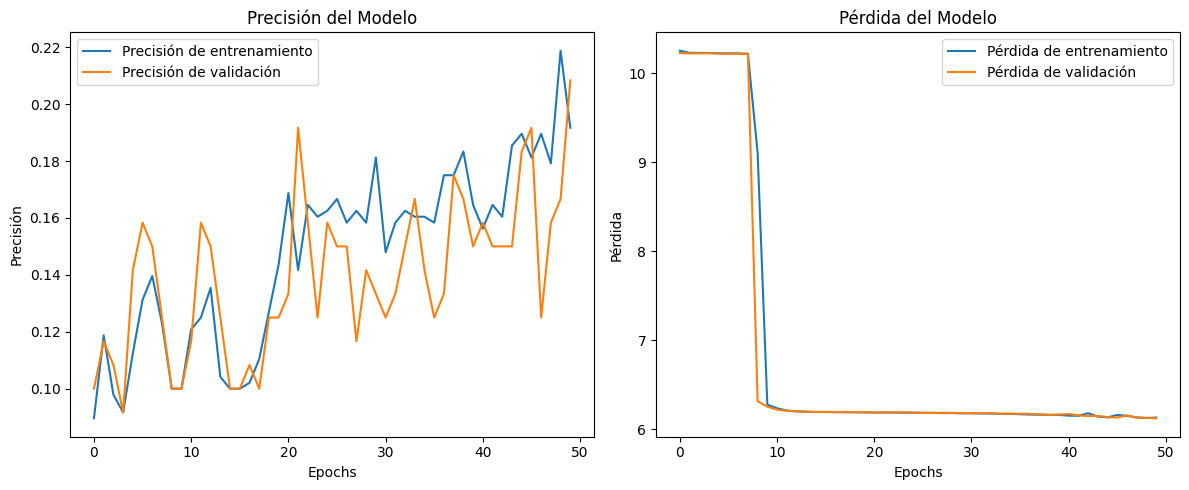


Posible Underfitting: precisión de validación por debajo del 60%.


In [ ]:
test_loss, test_accuracy = model.evaluate(val_data)

# Resultados de entrenamiento
print(f'\nPrecisión en el conjunto de test: {test_accuracy:.4f}')
print(f'Pérdida en el conjunto de test: {test_loss:.4f}')

# Gráfica de precisión y pérdida
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del Modelo')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

# Análisis de overfitting/underfitting basado en la diferencia entre entrenamiento y validación
if history.history['accuracy'][-1] - history.history['val_accuracy'][-1] > 0.2:
    print("\nPosible Overfitting detectado: gran diferencia entre precisión de entrenamiento y validación.")
elif history.history['val_accuracy'][-1] < 0.6:
    print("\nPosible Underfitting: precisión de validación por debajo del 60%.")
else:
    print("\nEl modelo parece estar entrenado correctamente.")

In [ ]:
# Predecir una imagen
img = keras.preprocessing.image.load_img(
    "./animals/animals/parrot/0b2a1e349a.jpg", target_size=(150, 150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f}% confidence."
    .format(categories[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
This image most likely belongs to lobster with a 100.00% confidence.


## Guardar el modelo

In [ ]:
model.save('model.keras')